# Translating Polygon Around Sphere While Preserving Area

### The Code

In [1]:
%matplotlib inline

In [2]:
import geopandas
import math
import shapely

In [3]:
CAMP_BOUNDARY_FILEPATH = "data/ShapeFile/CampBoundary"
SEATTLE_COORDS = (-122.31559, 47.663488)

In [4]:
camp_boundary = geopandas.read_file(CAMP_BOUNDARY_FILEPATH)

In [5]:
def move_polygon_across_spheres_surface(src_geodataframe, dest_centroid_coordinates):
    src_polygon_coordinates = list(src_geodataframe.geometry[0].exterior.coords)
    src_centroid_coordinates = list(src_geodataframe.centroid[0].coords)[0]
    
    src_centroid_long, src_centroid_lat = src_centroid_coordinates
    dest_centroid_long, dest_centroid_lat = dest_centroid_coordinates
        
    longitudinal_shift = dest_centroid_long - src_centroid_long
    latitudinal_shift = dest_centroid_lat - src_centroid_lat
    
    dest_polygon_coordinates = []
    for src_long, src_lat in src_polygon_coordinates:
        west_of_centroid_long = src_long < src_centroid_long  
        dist_from_centroid_long = abs(src_long - src_centroid_long)
        
        dest_lat = src_lat + latitudinal_shift
        
        src_long_radians = math.radians(src_long)
        src_lat_radians = math.radians(src_lat)
        dist_from_centroid_long_radians = math.radians(dist_from_centroid_long)
        dest_lat_radians = math.radians(dest_lat)
                
        a = math.sin(dest_lat_radians)**2
        b1 = math.sin(src_lat_radians)**2
        b2 = math.cos(src_lat_radians)**2 * math.cos(dist_from_centroid_long_radians)
        b = b1 + b2
        c = math.cos(dest_lat_radians)**2
        
        new_dist_from_centroid_long = math.degrees(math.acos((b - a)/c))
        delta_dist_from_centroid_long = new_dist_from_centroid_long - dist_from_centroid_long
        
        dest_long = src_long + longitudinal_shift
        if west_of_centroid_long:
            dest_long -= delta_dist_from_centroid_long
            if dest_long < -180:
                dest_long += 360
        else:
            dest_long += delta_dist_from_centroid_long
            if dest_long > +180:
                dest_long -= 360
            
        dest_polygon_coordinates.append((dest_long, dest_lat))
        
    dest_polygon = shapely.geometry.Polygon(dest_polygon_coordinates)
    dest_geodataframe = geopandas.GeoDataFrame(geometry=[dest_polygon])
    
    return dest_geodataframe

In [6]:
home_boundary = move_polygon_across_spheres_surface(camp_boundary, SEATTLE_COORDS)

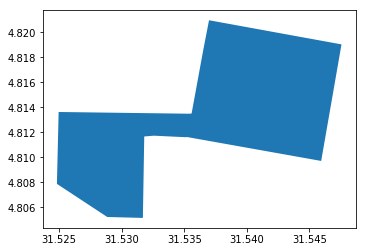

In [7]:
camp_boundary.plot()

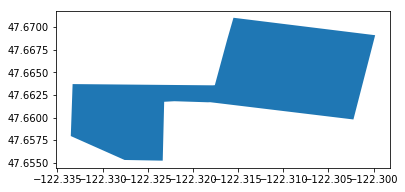

In [8]:
home_boundary.plot()

#### Juba refugee camp outline on Google Earth

![Juba Refugee Camp](img/juba_refugee_camp.jpg)

#### Juba refugee camp outline over University District on Google Earth

![My House](img/my_house.jpg)

### The Simple Web Application

[https://ryanbald.github.io/](https://ryanbald.github.io/)

### The Math

#### Longitudinal Shift

<img src="img/east_west_transform.jpg" alt="East-West Transform" width="50%"/>

#### Latitudinal Shift

<img src="img/south_north_transform.jpg" alt="South-North Transform" width="50%"/>

[Great-circle distance](https://en.wikipedia.org/wiki/Great-circle_distance)

$\phi_{1}$ = source latitude

$\Delta\lambda_{1}$ = difference between source longitude and central longitude of source polygon

$\phi_{2}$ = target latitude

$\Delta\lambda_{2}$ = difference between target longitude and central longitude of target polygon

<img src="img/variable_labels.jpg" alt="Variable Labels" width="50%"/>

$sin(\phi_{1})^{2} + cos(\phi_{1})^{2} \cdot cos(\Delta\lambda_{1}) = sin(\phi_{2})^{2} + cos(\phi_{2})^{2} \cdot cos(\Delta\lambda_{2})$

$b = a + c \cdot cos(\Delta\lambda_{2})$

$\Delta\lambda_{2} = cos^{-1}(\frac{b - a}{c})$